In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import numpy as np
from collections import namedtuple

Point = namedtuple('Point', 'x y z')

class Cube:
    def __init__(self, line: str):
        p = Point(*[int(v) for v in line.split(',')])
        self.p = p
        self.n = (
            Point(p.x - 1, p.y, p.z),
            Point(p.x + 1, p.y, p.z),
            Point(p.x, p.y - 1, p.z),
            Point(p.x, p.y + 1, p.z),
            Point(p.x, p.y, p.z - 1),
            Point(p.x, p.y, p.z + 1),
        )
        self.exposed: dict[Point, bool] = {}
        self.visited: dict[Point, bool] = {}
    
    def visit(self, p: Point):
        self.visited[p] = True
    
    def reset(self):
        self.visited = {}
    
    def get_surface_area(self, map: dict[Point, any]):
        for n in self.n:
            if n not in map:
                self.exposed[n] = True
        return len(self.exposed)
    
    def get_visited_area(self):
        return len(self.visited)

In [9]:
data = open('./data.txt', 'r').read().splitlines()
test_data = open('./testdata.txt', 'r').read().splitlines()

items = [Cube(line) for line in data]
cube_map = { c.p : c for c in items }

sum([n.get_surface_area(cube_map) for n in items])

3496

In [124]:
P2 = namedtuple('P2', 'x y')
Range = tuple[tuple[int, int], tuple[int, int]]

def is_in_bounds(p: P2, r: Range):
    return p.x >= r[0][0] and p.x <= r[1][0] and p.y >= r[0][1] and p.y <= r[1][1]

class Steam:
    def __init__(self, x: int, y: int, slice_range: Range):
        self.x = x
        self.y = y
        ns = [
            P2(self.x - 1, self.y),
            P2(self.x + 1, self.y),
            P2(self.x, self.y - 1),
            P2(self.x, self.y + 1),
        ]
        self.n = tuple([n for n in ns if is_in_bounds(n, slice_range)])
        self.r = slice_range
    
    def get_neighbors_for_z(self, z: int):
        return tuple(
            [Point(p.x, p.y, z) for p in self.n] + [self.get_up_for_z(z), self.get_down_for_z(z)],
        )

    def get_up_for_z(self, z: int):
        return Point(self.x, self.y, z + 1)
    
    def get_down_for_z(self, z: int):
        return Point(self.x, self.y, z - 1)
    
    def should_die_up(self, map, z):
        return self.get_up_for_z(z) in map

    def should_die_down(self, map, z):
        return self.get_down_for_z(z) in map
    
    def visit(self, slice: dict[P2, any], map: dict[Point, Cube], z):
        this_p = Point(self.x, self.y, z)
        for p in self.get_neighbors_for_z(z):
            if p in map:
                map[p].visit(this_p)
        for p in self.n:
            if p not in slice:
                p3 = Point(p.x, p.y, z)
                if p3 not in map:
                    new_steam = Steam(p.x, p.y, self.r)
                    slice[p] = new_steam
                    new_steam.visit(slice, map, z)

In [125]:
from itertools import product

p2_items = [Cube(line) for line in data]
p2_cube_map = { c.p : c for c in p2_items }

[n.get_surface_area(p2_cube_map) for n in p2_items]

x = set([n.p.x for n in p2_items])
y = set([n.p.y for n in p2_items])
z = set([n.p.z for n in p2_items])

(min_x, max_x) = (min(x), max(x))
(min_y, max_y) = (min(y), max(y))
(min_z, max_z) = (min(z), max(z))

slice_range = ((min_x - 1, min_y - 1), (max_x + 1, max_y + 1))

# slices = []
cur_slice = {P2(x, y) : Steam(x, y, slice_range) for x, y in product(
    range(slice_range[0][0], slice_range[1][0] + 1), 
    range(slice_range[0][1], slice_range[1][1] + 1)
)}
# slices.append(cur_slice)

for z in range(min_z -1, max_z + 2):
    for p, n in list(cur_slice.items()):
        n.visit(cur_slice, p2_cube_map, z)
    next_slice = cur_slice.copy()
    # slices.append(next_slice)
    for p, n in list(cur_slice.items()):
        if n.should_die_up(p2_cube_map, z):
            del next_slice[p]
    cur_slice = next_slice

for z in range(max_z + 1, min_z - 2, -1):
    for p, n in list(cur_slice.items()):
        n.visit(cur_slice, p2_cube_map, z)
    next_slice = cur_slice.copy()
    # slices.append(next_slice)
    for p, n in list(cur_slice.items()):
        if n.should_die_down(p2_cube_map, z):
            del next_slice[p]
    cur_slice = next_slice
    
sum([n.get_visited_area() for n in p2_items])

2064

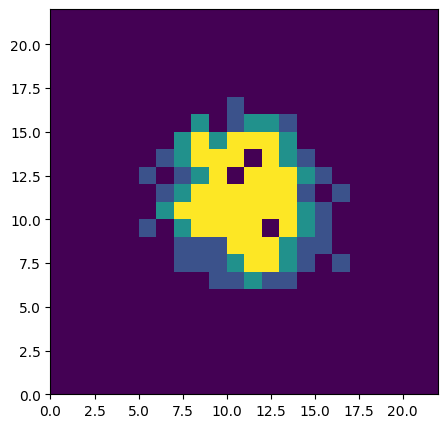

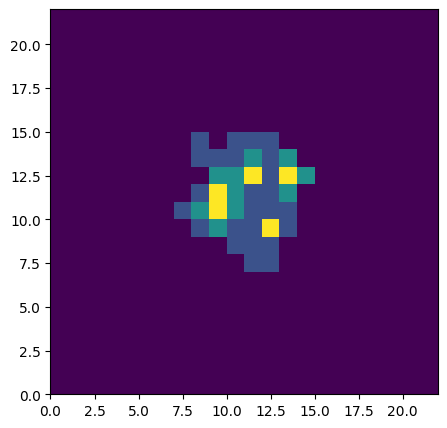

In [120]:
z = 18
create_image(p2_cube_map, z)
create_image(p2_cube_map, z + 1)

In [110]:
c1 = mpl.colormaps['viridis']

def create_image(map, z):
    sizex, sizey = max_x - min_x + 3, max_y - min_y + 3
    x_adj, y_adj = min_x - 1, min_y - 1
    grid = [[0] * sizex for i in range(sizey)]
    for p, n in map.items():
        if p.z == z:
            grid[p.y - y_adj][p.x - x_adj] = 2
            for q, o in n.visited.items():
                if q.z == z:
                    grid[q.y - y_adj][q.x - x_adj] = 1
        elif p.z == z + 1:
            for q, o in n.visited.items():
                if q.z == z:
                    grid[q.y - y_adj][q.x - x_adj] = 1.5
        elif p.z == z - 1:
            for q, o in n.visited.items():
                if q.z == z:
                    grid[q.y - y_adj][q.x - x_adj] = 0.5
            
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.pcolormesh(grid, cmap=c1, rasterized=True, vmin=0, vmax=2)